In [166]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import itertools

In [167]:
df=pd.read_csv('product a.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [168]:
df.head(15)

,Product Name,Product Category,Sales,Market Size,Marketing Expense
Month-Year,,,,,
2019-01-01,Product A,Pain/Analgesic,54555,2738080,177316
2019-02-01,Product A,Pain/Analgesic,54293,4637013,300290
2019-03-01,Product A,Pain/Analgesic,58798,7079920,458491
2019-04-01,Product A,Pain/Analgesic,53229,3744057,242463
2019-05-01,Product A,Pain/Analgesic,50558,4196578,271768
2019-06-01,Product A,Pain/Analgesic,56326,6396559,414237
2019-07-01,Product A,Pain/Analgesic,50125,2545212,164826
2019-08-01,Product A,Pain/Analgesic,56414,6294066,407600
2019-09-01,Product A,Pain/Analgesic,55658,5454980,353261


In [169]:
sales_a= df.drop(['Product Name','Product Category'],axis=1)

In [170]:
sales_a.shape

(60, 3)

In [171]:
sales_a.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Sales              60 non-null     int64
 1   Market Size        60 non-null     int64
 2   Marketing Expense  60 non-null     int64
dtypes: int64(3)
memory usage: 1.9 KB


In [172]:
print('Total Sales:', sales_a['Sales'].sum())
print('Total Market Size:',sales_a['Market Size'].sum())
print('Total Marketing Expense:', sales_a['Marketing Expense'].sum())

Total Sales: 3213992
Total Market Size: 360874201
Total Marketing Expense: 19873176


Text(0.5, 1.0, 'Product A')

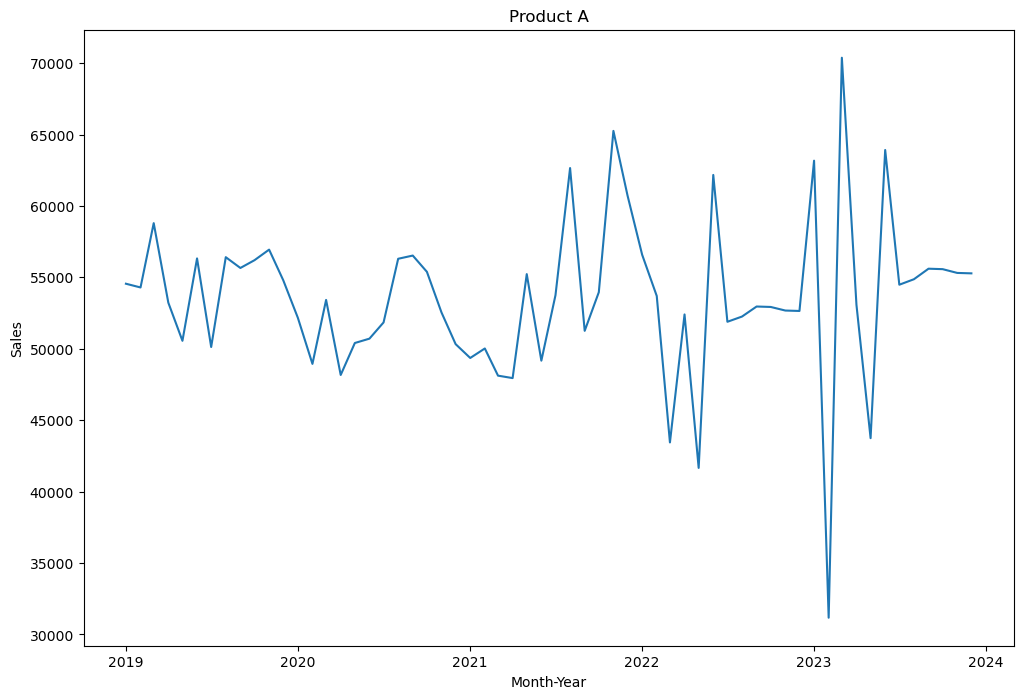

In [173]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_a['Sales'])
plt.title('Product A')

In [174]:
from statsmodels.tsa.stattools import adfuller

In [175]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [176]:
adf_test(sales_a['Sales'])

ADF Statistics: -10.095004165158468
p- value: 1.0967344875767964e-17
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


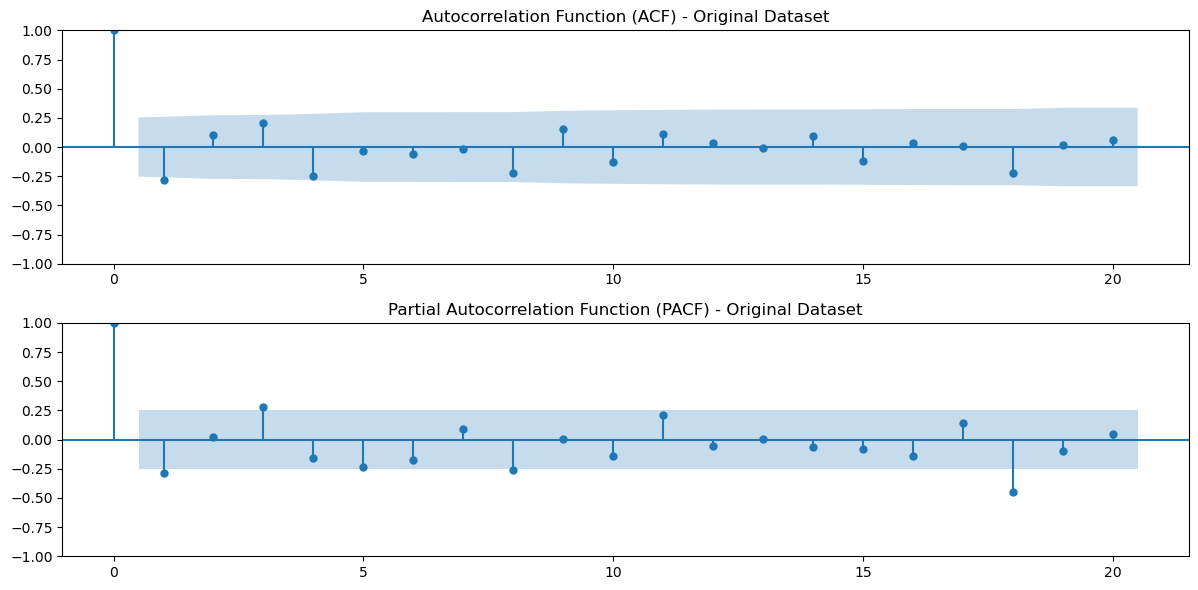

In [177]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_a['Sales'], lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Dataset')

plt.subplot(212)
plot_pacf(sales_a['Sales'], lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Dataset')

plt.tight_layout()
plt.show()

In [178]:
train= sales_a[:54]
test=sales_a[54:]

In [179]:
print(len(train),len(test))

54 6


In [180]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(2):
        # Fit model        
#       model= ARIMA(sales_b, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,0,q), exog=train[['Market Size','Marketing Expense']])
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_a)-1), exog=test[['Market Size','Marketing Expense']])
        mae = mean_absolute_error(test['Sales'], pred)
        mape = np.mean(np.abs((test['Sales'] - pred) / test)) * 100
        mse=mean_squared_error(test['Sales'], pred)
        rmse = np.sqrt(mean_squared_error(test['Sales'], pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [181]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic          mae           mse         rmse
10  5  0  1097.304767  1115.205624  4051.015572  1.822327e+07  4268.872559
8   4  0  1098.049588  1113.961460  3532.282806  1.958927e+07  4425.977226
2   1  0  1098.218529  1108.163450  1487.762021  3.273648e+06  1809.322517
6   3  0  1098.753422  1112.676311  1653.531316  5.470705e+06  2338.953780
11  5  1  1099.227351  1119.117191  3705.986324  1.590100e+07  3987.606423
1   0  1  1099.352718  1109.297638   858.487473  1.207573e+06  1098.896158
9   4  1  1099.613341  1117.514197  3291.476319  1.771901e+07  4209.395436
4   2  0  1100.245102  1112.179006  1505.266406  3.348454e+06  1829.878274
3   1  1  1100.307498  1112.241402  1483.334523  3.261620e+06  1805.995467
7   3  1  1101.833744  1117.745616  1543.046020  4.330475e+06  2080.979433
5   2  1  1108.416498  1122.339386   802.484636  8.488672e+05   921.339882
0   0  0  1264.422928  1272.378865   802.186759  8.484252e+05   921.100005


In [182]:
m_arima= ARIMA(train['Sales'], order=(5,0,0), exog=train[['Market Size','Marketing Expense']])
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   54
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -539.652
Date:                Tue, 14 May 2024   AIC                           1097.305
Time:                        20:22:29   BIC                           1115.206
Sample:                    01-01-2019   HQIC                          1104.208
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              5.312e+04   7.12e-06   7.46e+09      0.000    5.31e+04    5.31e+04
Market Size          -0.0002      0.000     -0.636      0.525      -0.001       0.000
Marketing Expense     0.

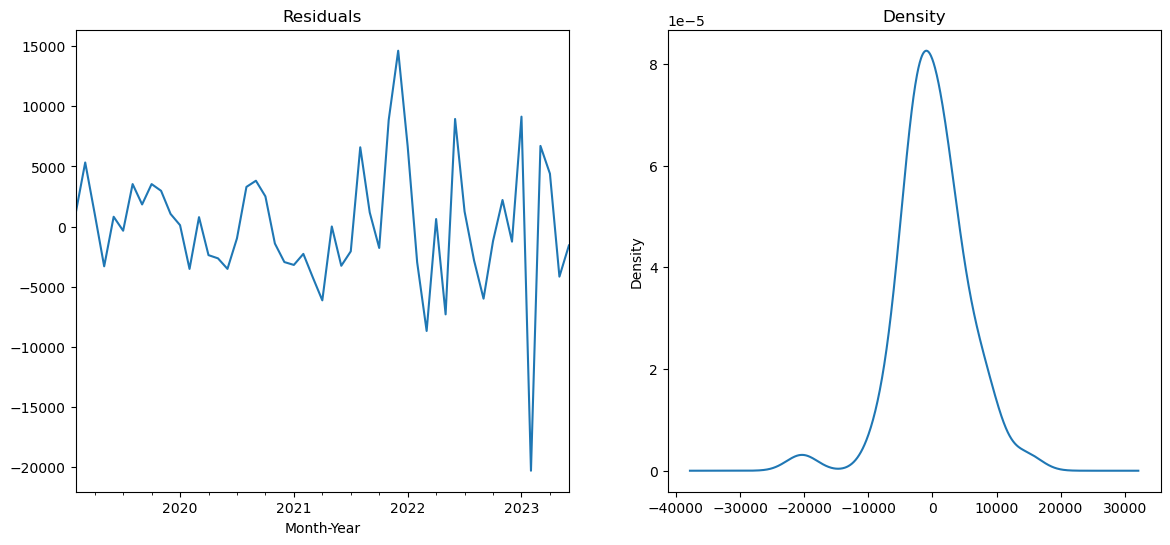

In [183]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

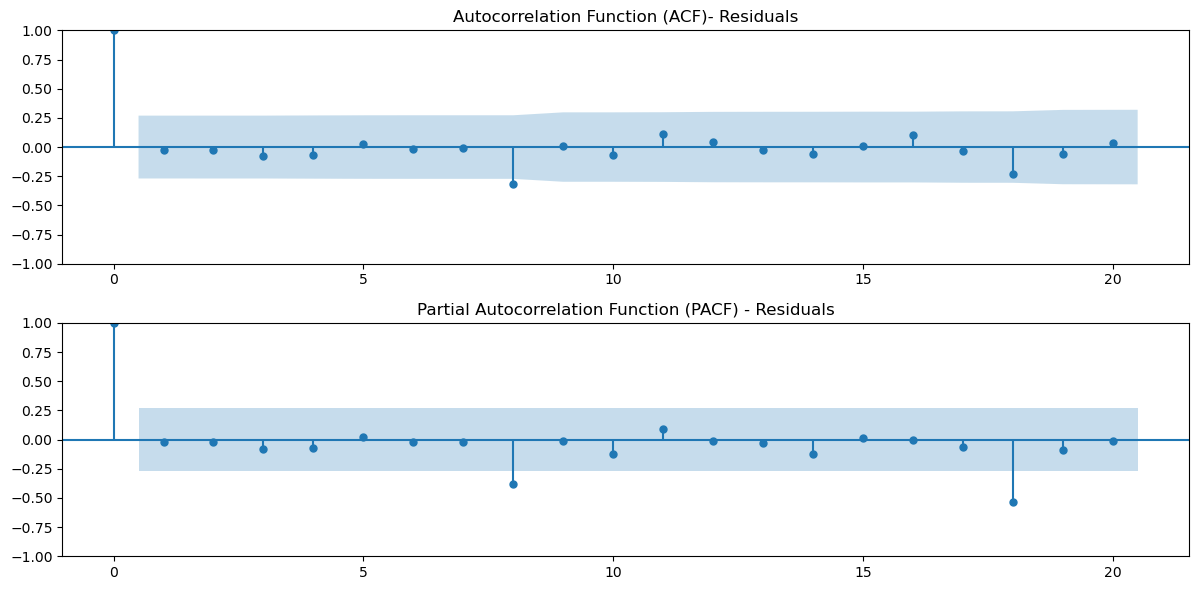

In [184]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

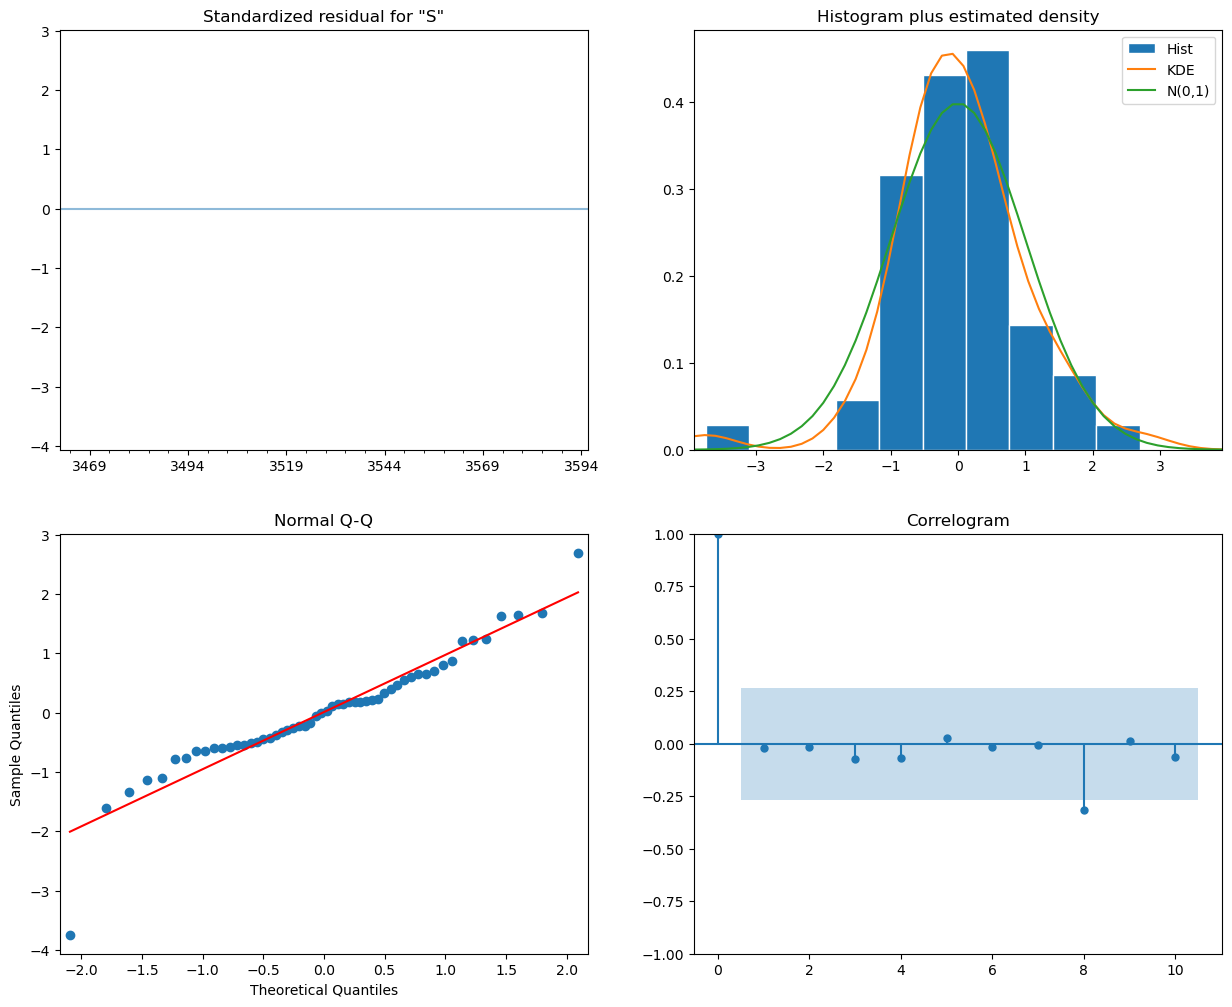

In [185]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [186]:
#pred_in_sample = model_arima.get_prediction(start=len(train), end=(len(sales_b)-1))
#sales_b['Forecast_ARIMA_p']=[None]*len(train) + list(pred)

In [187]:
#plt.figure(figsize=(12, 8))
#sns.lineplot(sales_b[['Sales','Forecast_ARIMA_p']])
#plt.title('Product B')
#plt.show()

In [188]:
pred=model_arima.predict(start=len(train), end=(len(sales_a)-1), exog=test[['Market Size','Marketing Expense']], dynamic = True)
sales_a['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

In [189]:
#pred=model_arima.forecast(steps= len(test))
#sales_b['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

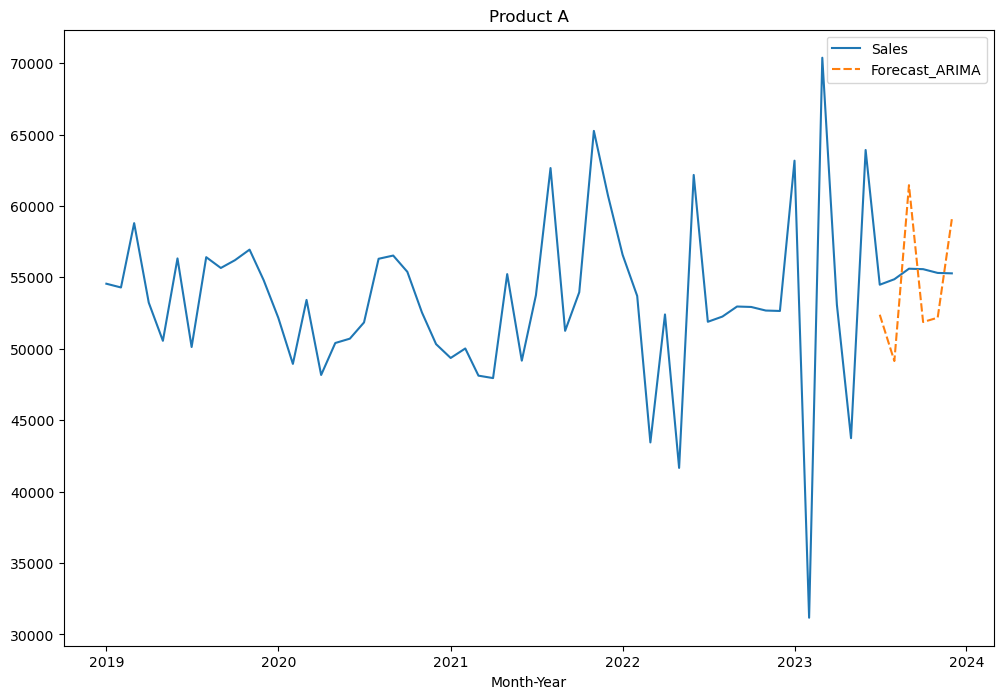

In [190]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales','Forecast_ARIMA']])
plt.title('Product A')
plt.show()

In [191]:
mae_arima= mean_absolute_error(test['Sales'],pred)
mse_arima=mean_squared_error(test['Sales'], pred)
mape_arima= mean_absolute_percentage_error(test['Sales'],pred)
rmse_arima= np.sqrt(mean_squared_error(test['Sales'],pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 4051.015572434227
MAPE - ARIMA: 0.07333506860455737
MSE - ARIMA: 18223272.92306469
RMSE - ARIMA: 4268.87255877529


# SARIMA

In [192]:
import statsmodels.api as sm

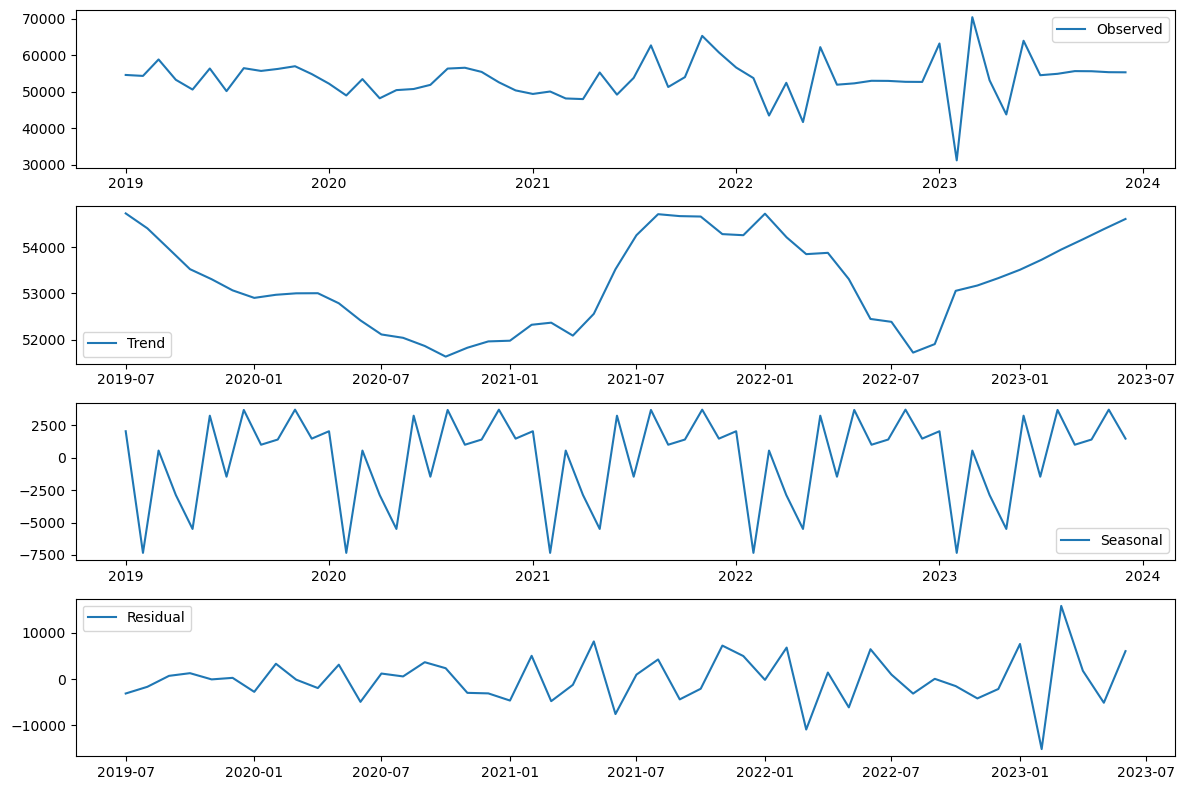

In [193]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_a['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

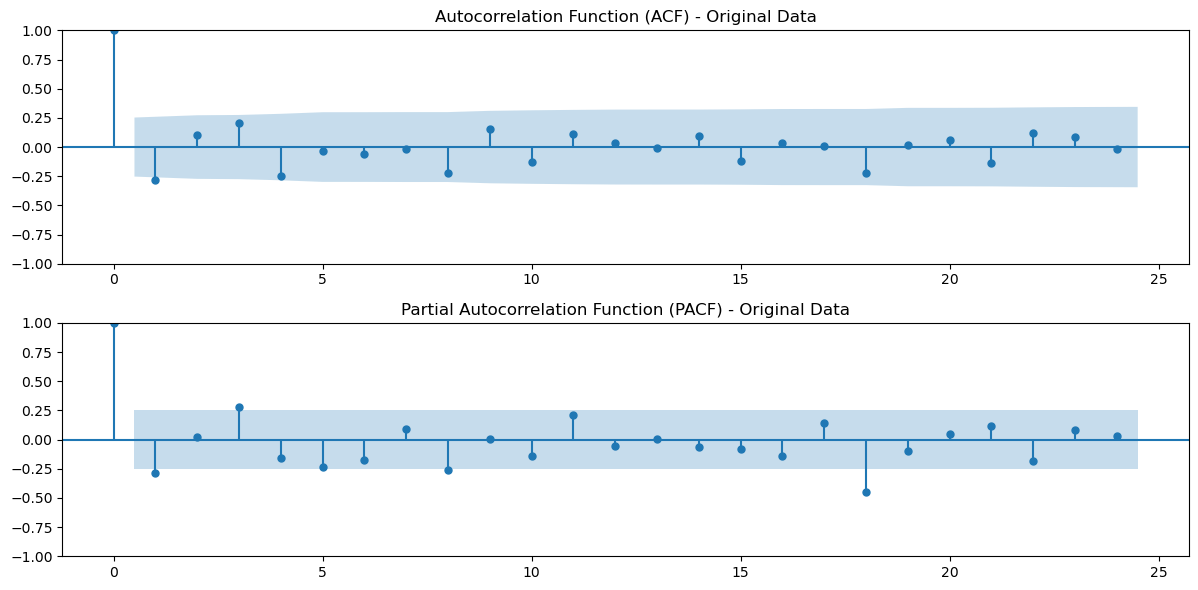

In [194]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_a['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_a['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

In [195]:
order_SARIMAX=[]
# Loop over P order
for P in range(6):
    # Loop over Q order
    for Q in range(2):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(5, 0, 0), seasonal_order=(P, 1, Q, 12),exog=train[['Market Size','Marketing Expense']])
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=54, end=59, dynamic=True, exog=test[['Market Size','Marketing Expense']])
        mae = mean_absolute_error(test['Sales'], pred)
        mse = mean_squared_error(test['Sales'], pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])


In [196]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

    P  Q         aic         bic          mae           mse
0   0  0  882.658071  896.559428   687.774258  5.961638e+05
2   1  0  884.471859  900.110885  1463.906970  3.169325e+06
1   0  1  884.696289  900.335316   715.752815  7.241946e+05
4   2  0  886.369089  903.745786  1674.269296  3.007435e+06
3   1  1  886.702814  904.079510  1078.802529  1.963500e+06
6   3  0  890.138882  909.253248  3131.913158  1.628910e+07
5   2  1  890.298473  909.412839  2220.170002  6.685550e+06
10  5  0  891.620257  914.209962  1744.769272  3.973662e+06
8   4  0  892.228102  913.080138  2620.595815  1.019520e+07
7   3  1  892.716111  913.568147  3026.651382  1.540552e+07
9   4  1  892.840989  915.430694  2918.658339  1.240590e+07
11  5  1  896.313646  920.641021  2790.060503  1.301518e+07


In [197]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(5, 0, 0),seasonal_order=(0,0,0,12),exog=train[['Market Size','Marketing Expense']])
sarima_model=sarima.fit()
print(sarima_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   54
Model:               SARIMAX(5, 0, 0)   Log Likelihood                -575.297
Date:                Tue, 14 May 2024   AIC                           1166.593
Time:                        20:27:20   BIC                           1182.505
Sample:                    01-01-2019   HQIC                          1172.730
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Market Size           0.0007      0.003      0.261      0.794      -0.005       0.006
Marketing Expense    -0.0044      0.044     -0.099      0.921      -0.091       0.082
ar.L1                -0.

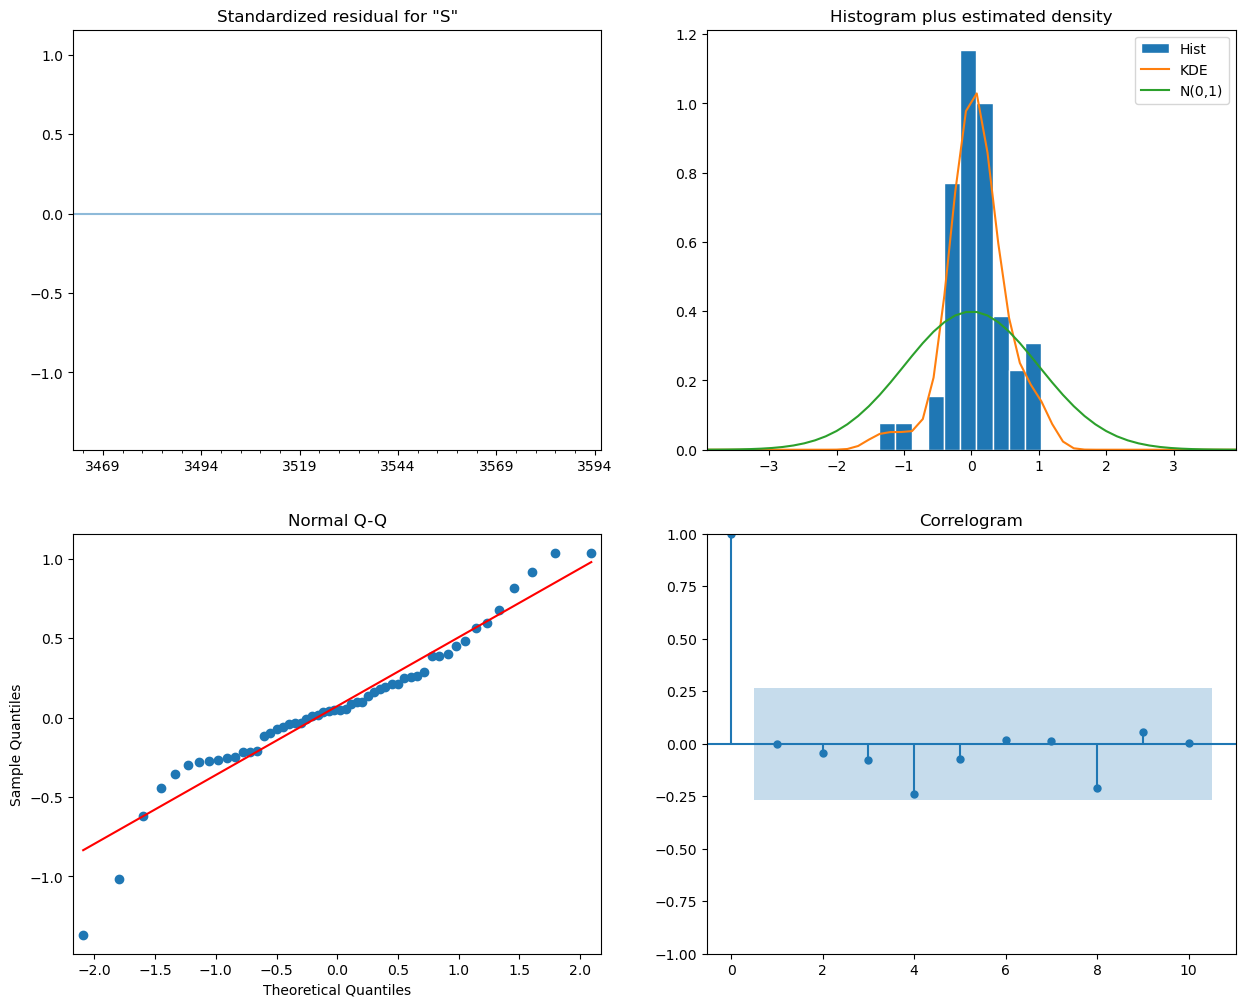

In [198]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [199]:
forecast_test_sarima=sarima_model.predict(start=54, end=59, dynamic=True, exog=test[['Market Size','Marketing Expense']])

In [200]:
sales_a['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product A')

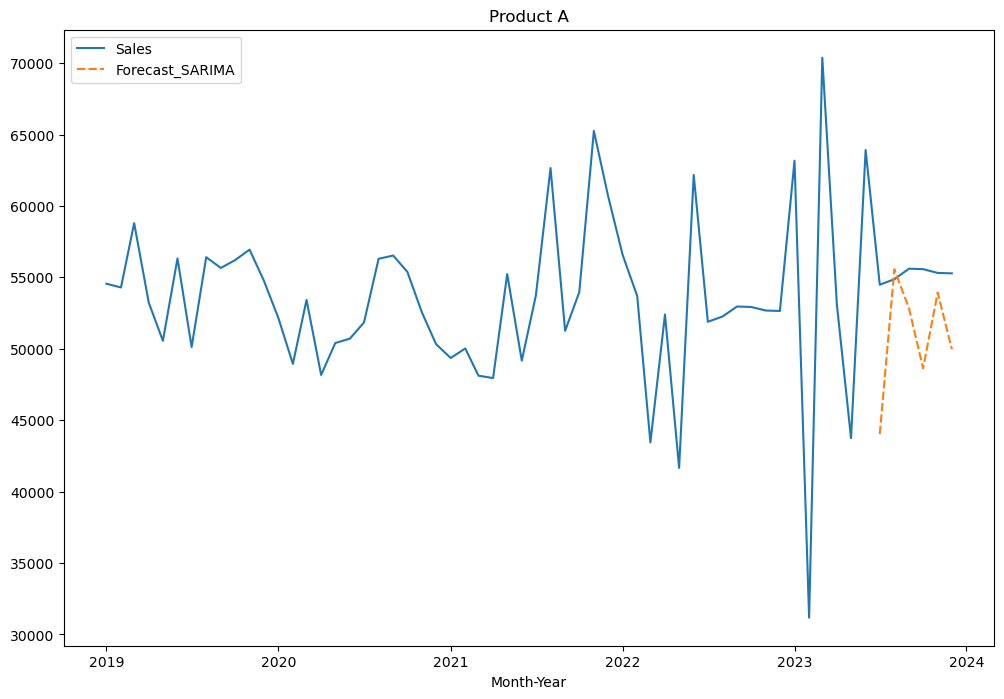

In [201]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales','Forecast_SARIMA']])
plt.title('Product A')

In [202]:
mae_sarima= mean_absolute_error(test['Sales'],forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test['Sales'],forecast_test_sarima)
mse_sarima=mean_squared_error(test['Sales'], forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test['Sales'],forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 4589.144
MAPE - SARIMA: 0.083
MSE - SARIMA: 32619913.676
RMSE - SARIMA: 5711.385


# AUTO-ARIMA

In [203]:
import pmdarima as pm

In [204]:
auto_arima= pm.auto_arima(train['Sales'], start_p=0,  start_q=0, max_p=6,max_q=2,
                          start_P=0, start_Q=0, max_P=6 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12, exogenous=train[['Market Size','Marketing Expense']])
auto_arima

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1098.299, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1100.139, Time=0.04 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1101.957, Time=0.09 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1100.298, Time=0.05 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1102.139, Time=0.28 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1103.957, Time=0.26 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1101.972, Time=0.11 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=1103.972, Time=0.53 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=1105.956, Time=0.53 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=1103.753, Time=0.80 sec
 ARIMA(0,0,0)(3,0,1)[12] intercept   : AIC=1105.709, Time=1.92 sec
 ARIMA(0,0,0)(3,0,2)[12] intercept   : AIC=1107.298, Time=3.58 sec
 ARIMA(0,0,0)(4,0,0)[12] intercept   : AIC=1105.623, Time=6.74 sec
 ARIMA(0,0,0)(4,0,1)[12] intercept   : AIC=1107.258, Time=7.29 sec
 ARIMA(0,0,0)(5,0,0)[12] intercept   : AIC=1107.372, Time=9.34

ARIMA(order=(2, 0, 2), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [205]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   54
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -539.908
Date:                Tue, 14 May 2024   AIC                           1091.816
Time:                        20:29:31   BIC                           1103.750
Sample:                    01-01-2019   HQIC                          1096.419
                         - 06-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8.899e+04   1.55e+04      5.757      0.000    5.87e+04    1.19e+05
ar.L1         -0.1102      0.146     -0.756      0.450      -0.396       0.175
ar.L2         -0.5571      0.202     -2.756      0.006      -0.953      -0.161
ma.L1         -0.2188      0.108     -2.032      0.042      -0.430      -0.008
ma.L2          0.9662      0.166      5.808      0.000       0.640       1.292
sigma2       3.27e+07      7.696   4.25e+06      0.000    3.27e+07    3.27e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 8.91
Prob(Q):                              0.94   Prob(JB):                         0.01
Heteroskedasticity (H):               5.69   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.79e+22. Standard errors may be unstable.
"""

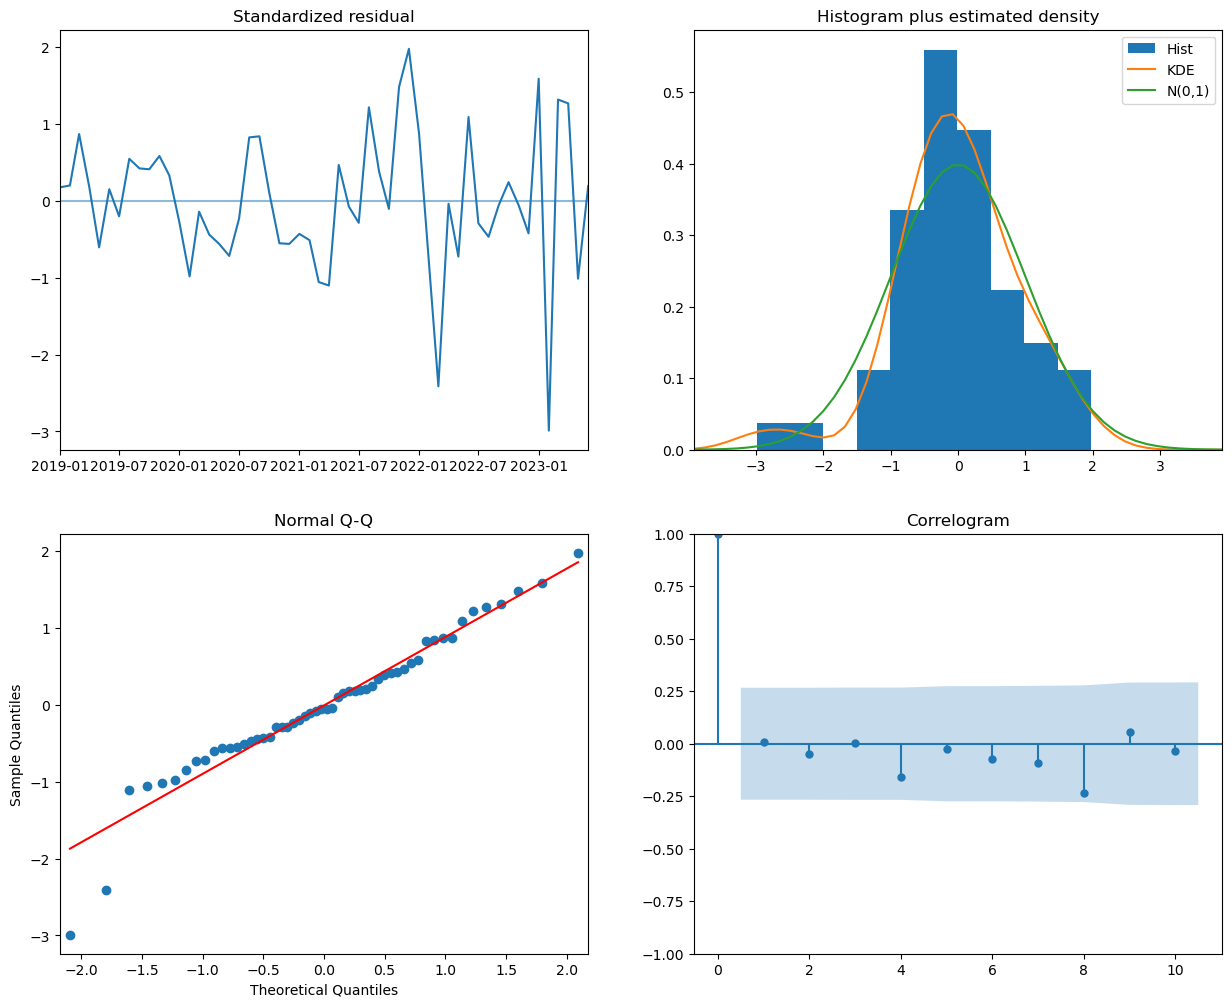

In [206]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [207]:
forecast_test_auto= auto_arima.predict(n_periods=len(test), exogenous=test[['Market Size','Marketing Expense']])
sales_a['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_b[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product A')

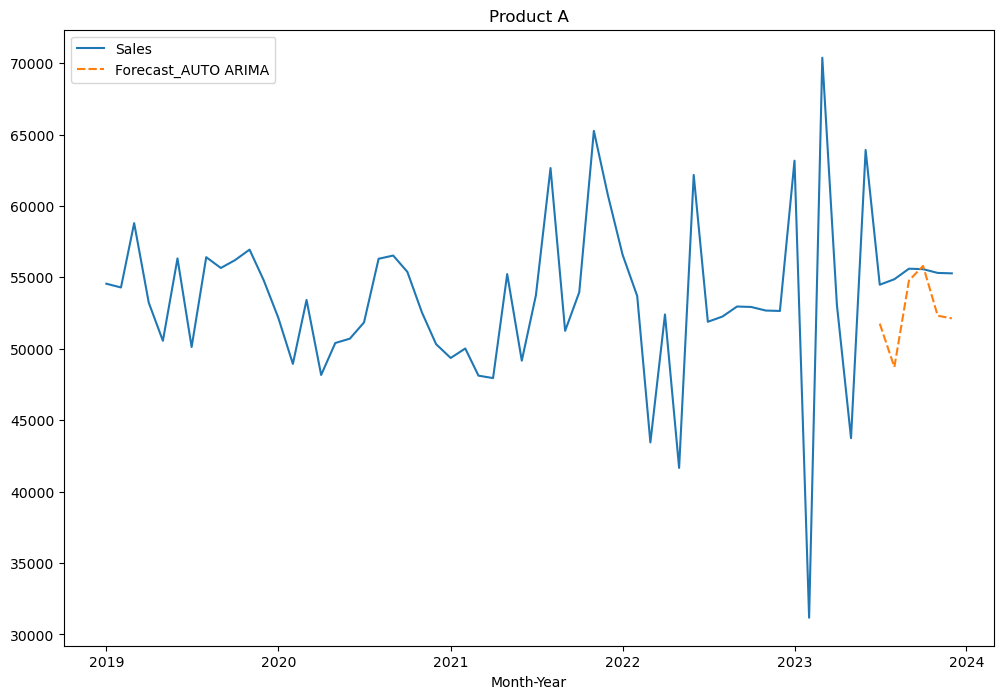

In [208]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_a[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product A')

In [209]:
mae_auto_arima= mean_absolute_error(test['Sales'],forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test['Sales'],forecast_test_auto)
mse_auto_arima=mean_squared_error(test['Sales'],forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test['Sales'],forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 2679.465095722038
MAPE - AUTO ARIMA: 0.048705964286983545
MSE - AUTO ARIMA: 10810511.423308944
RMSE - AUTO ARIMA: 3287.934218214979


In [210]:
sales_a.tail(12)

,Sales,Market Size,Marketing Expense,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,,,
2023-01-01,63171,2955148,236101,NaN,NaN,NaN
2023-02-01,31168,10151977,811092,NaN,NaN,NaN
2023-03-01,70380,5636182,450302,NaN,NaN,NaN
2023-04-01,53078,9134343,729788,NaN,NaN,NaN
2023-05-01,43741,3980872,318051,NaN,NaN,NaN
2023-06-01,63919,9490711,758260,NaN,NaN,NaN
2023-07-01,54485,5339196,426575,52384.258099,44026.778371,51758.912062
2023-08-01,54869,9714819,776165,49141.857317,55561.996056,48721.986895
2023-09-01,55607,5938316,474441,61456.224620,52842.692783,54778.100692


In [163]:
sales_a.mean()

Sales                  5.356653e+04
Market Size            6.014570e+06
Marketing Expense      3.312196e+05
Forecast_ARIMA         5.425402e+04
Forecast_SARIMA        5.490070e+04
Forecast_AUTO ARIMA    5.422223e+04
dtype: float64

In [164]:
sales_a.tail(12)

,Sales,Market Size,Marketing Expense,Forecast_ARIMA,Forecast_SARIMA,Forecast_AUTO ARIMA
Month-Year,,,,,,
2023-01-01,63171,2955148,236101,NaN,NaN,NaN
2023-02-01,31168,10151977,811092,NaN,NaN,NaN
2023-03-01,70380,5636182,450302,NaN,NaN,NaN
2023-04-01,53078,9134343,729788,NaN,NaN,NaN
2023-05-01,43741,3980872,318051,NaN,NaN,NaN
2023-06-01,63919,9490711,758260,NaN,NaN,NaN
2023-07-01,54485,5339196,426575,NaN,NaN,NaN
2023-08-01,54869,9714819,776165,NaN,NaN,NaN
2023-09-01,55607,5938316,474441,NaN,NaN,NaN


In [165]:
data = {
    'model': ['ARIMAX', 'AUTO ARIMAX', 'SEASONAL ARIMAX'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMAX,1519.272467,0.027455,4.175902e+06,2043.502303
AUTO ARIMAX,3150.413339,0.056888,1.103816e+07,3322.372965
SEASONAL ARIMAX,670.152460,0.012112,8.619638e+05,928.420075


# TESTING

In [43]:
auto_arima_1= pm.auto_arima(train['Sales'], start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12, exogenous=train[['Market Size','Marketing Expense']])
auto_arima_1

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1374.393, Time=0.03 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1376.384, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1377.119, Time=0.16 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1376.387, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1378.263, Time=0.10 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1378.671, Time=0.23 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1377.144, Time=0.09 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1378.530, Time=0.22 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1380.459, Time=0.51 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1350.206, Time=0.04 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1350.297, Time=0.10 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1351.489, Time=0.18 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1352.086, Time=0.10 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIM

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [44]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(3, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -660.560
Date:                            Wed, 08 May 2024   AIC                           1335.120
Time:                                    18:26:04   BIC                           1348.071
Sample:                                01-01-2019   HQIC                          1339.994
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.218e+04   2.76e+04      1.529      0.126   -1.19e+04    9.63e+04
ar.L1         -0.7728      0.212     -3.647      0.000      -1.188      -0.358
ar.L2         -0.4947      0.256     -1.934      0.053      -0.996       0.007
ar.L3         -0.3294      0.161     -2.051      0.040      -0.644      -0.015
ma.L1         -0.6157      0.175     -3.516      0.000      -0.959      -0.272
ma.S.L12       0.3138      0.234      1.340      0.180      -0.145       0.773
sigma2       8.38e+10      0.007   1.17e+13      0.000    8.38e+10    8.38e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.40   Prob(JB):                         0.64
Heteroskedasticity (H):               1.03   Skew:                            -0.17
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.21e+29. Standard errors may be unstable.
"""

In [49]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test), exogenous=test[['Market Size','Marketing Expense']])
sales_b['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)

Text(0.5, 1.0, 'Product B')

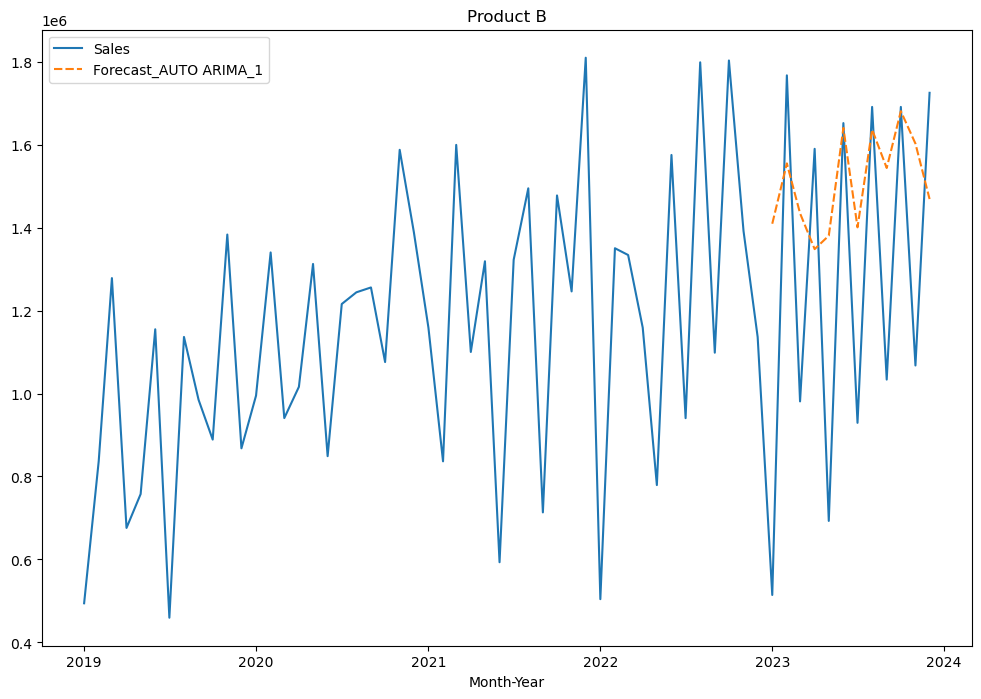

In [50]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product B')

In [51]:
mae_auto_arima_1= mean_absolute_error(test['Sales'],forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test['Sales'],forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test['Sales'],forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test['Sales'],forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 361595.78675793833
MAPE - AUTO ARIMA: 0.4301972486948735
MSE - AUTO ARIMA: 201684310197.0093
RMSE - AUTO ARIMA: 449092.7634654218
